In [1]:
import torch
device = 'cuda' if torch.cuda.is_available else 'cpu'
from agent import Agent, advanced_random_policy, random_policy, sarsa
from game import Game
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Trains and test a single Agent

agent = Agent(size=3)
random_agent = Agent(size=3, policy=advanced_random_policy)
game = Game(agent, random_agent, n_dim=2, size=3)
sarsa(game, agent, random_policy, alpha=0.8, alpha_factor=0.999, gamma=0.9, epsilon=1.0, epsilon_factor=0.999, \
      r_win=5.0, r_lose=0.0, r_even=1.0, r_even2=1.5, num_episodes=10000)

100%|██████████| 10000/10000 [01:15<00:00, 132.39it/s]


In [3]:
game.simulate_games(1000)

(0, 0, 500, 35, 148, 317)

In [4]:
game.play_a_game()

. . . 
. . . 
. . . 

Agent plays : (1, 1) 

. . . 
. X . 
. . . 

Agent plays : (2, 1) 

. . . 
. X . 
. O . 

Agent plays : (2, 0) 

. . . 
. X . 
X O . 

Agent plays : (0, 2) 

. . O 
. X . 
X O . 

Agent plays : (1, 2) 

. . O 
. X X 
X O . 

Agent plays : (1, 0) 

. . O 
O X X 
X O . 

Agent plays : (0, 0) 

X . O 
O X X 
X O . 

Agent plays : (2, 2) 

X . O 
O X X 
X O O 

Agent plays : (0, 1) 

X X O 
O X X 
X O O 

Game over. Score : (0, 0)
Even score.


(0, 0)

In [5]:
# Evaluates agents performances based on number of episodes
episodes = [1, 10, 100, 500, 1000, 5000, 10000]
results_episodes = dict()
for eps in episodes:
    print(f"Testing with {eps} episodes")
    agent = Agent(size=3)
    random_agent = Agent(size=3, policy=random_policy)
    game = Game(agent, random_agent, n_dim=2, size=3)
    sarsa(game, agent, random_policy, alpha=0.45, alpha_factor=0.9995, gamma=0.7, epsilon=1.0, epsilon_factor=0.9997, \
          r_win=11, r_lose=0.0, r_even=1.0, r_even2=1.25, num_episodes=eps)
    results_episodes[eps] = game.simulate_games(10000)
    print(f"Current results are {results_episodes}")
results_episodes = pd.DataFrame(results_episodes).T
results_episodes.columns = ["win_agent_first", "lose_agent_first", "even_agent_first", "win_agent_second", "lose_agent_second", "even_agent_second"]

100%|██████████| 10000/10000 [01:05<00:00, 151.80it/s]


Testing with 1 episodes
Current results are {1: (2997, 1382, 621, 1411, 2903, 686)}
Testing with 10 episodes
Current results are {1: (2997, 1382, 621, 1411, 2903, 686), 10: (2903, 1529, 568, 1550, 2872, 578)}
Testing with 100 episodes
Current results are {1: (2997, 1382, 621, 1411, 2903, 686), 10: (2903, 1529, 568, 1550, 2872, 578), 100: (3539, 981, 480, 2116, 2626, 258)}
Testing with 500 episodes
Current results are {1: (2997, 1382, 621, 1411, 2903, 686), 10: (2903, 1529, 568, 1550, 2872, 578), 100: (3539, 981, 480, 2116, 2626, 258), 500: (4103, 534, 363, 1981, 1700, 1319)}
Testing with 1000 episodes
Current results are {1: (2997, 1382, 621, 1411, 2903, 686), 10: (2903, 1529, 568, 1550, 2872, 578), 100: (3539, 981, 480, 2116, 2626, 258), 500: (4103, 534, 363, 1981, 1700, 1319), 1000: (4638, 248, 114, 3311, 882, 807)}
Testing with 5000 episodes
Current results are {1: (2997, 1382, 621, 1411, 2903, 686), 10: (2903, 1529, 568, 1550, 2872, 578), 100: (3539, 981, 480, 2116, 2626, 258), 500

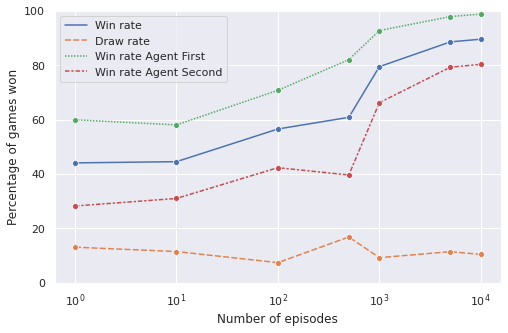

In [6]:
sns.set_theme()
sns.set(rc={'figure.figsize':(8,5)})
results_episodes["total_games"] = results_episodes["win_agent_first"] + results_episodes["win_agent_second"] + \
                                  results_episodes["lose_agent_first"] + results_episodes["lose_agent_second"] + \
                                  results_episodes["even_agent_first"] + results_episodes["even_agent_second"]
results_episodes["Win rate"] = ((results_episodes["win_agent_first"] + results_episodes["win_agent_second"]) / results_episodes["total_games"]) * 100
results_episodes["Draw rate"] = ((results_episodes["even_agent_first"] + results_episodes["even_agent_second"]) / results_episodes["total_games"]) * 100
results_episodes["Win rate Agent First"] = ((results_episodes["win_agent_first"]) / (results_episodes["win_agent_first"] + results_episodes["lose_agent_first"] + results_episodes["even_agent_first"])) * 100
results_episodes["Win rate Agent Second"] = ((results_episodes["win_agent_second"]) / (results_episodes["win_agent_second"] + results_episodes["lose_agent_second"] + results_episodes["even_agent_second"])) * 100

ax = sns.lineplot(data=results_episodes[["Win rate", "Draw rate", "Win rate Agent First", "Win rate Agent Second"]], marker="o")
ax.set(xlabel='Number of episodes', ylabel='Percentage of games won', ylim=(0, 100))
ax.set(xscale="log")
ax.legend(loc='upper left')
plt.savefig("Perf_vs_Episodes.png")
plt.show()

In [7]:
# Evaluates agents performances based on board size
board_sizes = [3, 4, 5, 6, 7]
results_boardsize = dict()
for board_size in board_sizes:
    print(f"Testing board of size {board_size}x{board_size}")
    agent = Agent(size=board_size)
    random_agent = Agent(size=board_size, policy=random_policy)
    game = Game(agent, random_agent, n_dim=2, size=board_size)
    # Early stopping ?
    sarsa(game, agent, random_policy, alpha=0.45, alpha_factor=0.9995, gamma=0.7, epsilon=1.0, epsilon_factor=0.9997, \
          r_win=11, r_lose=0.0, r_even=1.0, r_even2=1.25, num_episodes=10000)
    results_boardsize[agent.q_array.shape[0]] = game.simulate_games(10000)
    print(f"Current results are {results_boardsize}")
results_boardsize = pd.DataFrame(results_boardsize).T
results_boardsize.columns = ["win_agent_first", "lose_agent_first", "even_agent_first", "win_agent_second", "lose_agent_second", "even_agent_second"]

100%|██████████| 10000/10000 [2:29:17<00:00,  1.12it/s] 


Testing board of size 3x3
Current results are {627: (4908, 0, 92, 4071, 32, 897)}
Testing board of size 4x4
Current results are {627: (4908, 0, 92, 4071, 32, 897), 45507: (1556, 1410, 2034, 1458, 1552, 1990)}
Testing board of size 5x5
Current results are {627: (4908, 0, 92, 4071, 32, 897), 45507: (1556, 1410, 2034, 1458, 1552, 1990), 97815: (1088, 827, 3085, 751, 1270, 2979)}
Testing board of size 6x6
Current results are {627: (4908, 0, 92, 4071, 32, 897), 45507: (1556, 1410, 2034, 1458, 1552, 1990), 97815: (1088, 827, 3085, 751, 1270, 2979), 156481: (570, 635, 3795, 604, 623, 3773)}
Testing board of size 7x7
Current results are {627: (4908, 0, 92, 4071, 32, 897), 45507: (1556, 1410, 2034, 1458, 1552, 1990), 97815: (1088, 827, 3085, 751, 1270, 2979), 156481: (570, 635, 3795, 604, 623, 3773), 225070: (403, 324, 4273, 303, 416, 4281)}


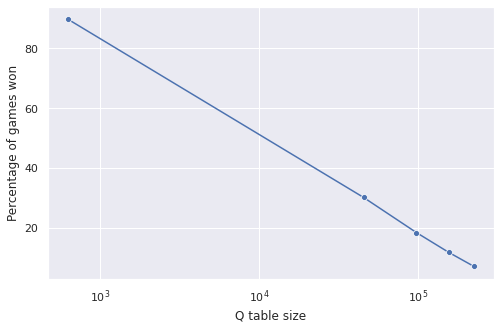

In [8]:
results_boardsize["total_games"] = results_boardsize["win_agent_first"] + results_boardsize["win_agent_second"] + \
                                  results_boardsize["lose_agent_first"] + results_boardsize["lose_agent_second"] + \
                                  results_boardsize["even_agent_first"] + results_boardsize["even_agent_second"]
results_boardsize["Win rate"] = ((results_boardsize["win_agent_first"] + results_boardsize["win_agent_second"]) / results_boardsize["total_games"]) * 100

ax = sns.lineplot(data=results_boardsize["Win rate"], marker="o")
ax.set(xlabel='Q table size', ylabel='Percentage of games won')
ax.set(xscale="log")
plt.savefig("Perf_vs_BoardSize.png")
plt.show()

In [1]:
import neuralAgent as na
import torch
device = 'cuda' if torch.cuda.is_available else 'cpu'
from game import Game

game = Game(None, None, n_dim=2, size=3)
agent1 = na.Model()
agent1, values, _, _, _ =na.train_network(agent1, game, 15000, 1000)
print(values)

  7%|▋         | 991/15000 [00:05<01:35, 146.38it/s]/usr/lib/python3.9/site-packages/torch/autograd/__init__.py:144: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:104.)
  Variable._execution_engine.run_backward(
100%|██████████| 15000/15000 [01:20<00:00, 186.02it/s]


[array(0.18835607, dtype=float32), array(0.18835607, dtype=float32), array(0.22811754, dtype=float32), array(0.22811754, dtype=float32), array(0.23030327, dtype=float32), array(0.23030327, dtype=float32), array(0.2119978, dtype=float32), array(0.2119978, dtype=float32), array(0.22302455, dtype=float32), array(0.22302455, dtype=float32), array(0.22132683, dtype=float32), array(0.22132683, dtype=float32), array(0.23356548, dtype=float32), array(0.23356548, dtype=float32), array(0.21245217, dtype=float32), array(0.21245217, dtype=float32), array(0.21925487, dtype=float32), array(0.21925487, dtype=float32), array(0.22709873, dtype=float32), array(0.22709873, dtype=float32), array(0.22639814, dtype=float32), array(0.22639814, dtype=float32), array(0.24171913, dtype=float32), array(0.24171913, dtype=float32), array(0.2359729, dtype=float32), array(0.2359729, dtype=float32), array(0.23264071, dtype=float32), array(0.23264071, dtype=float32)]


In [2]:
wins, draw, loses = na.test_against_random(agent1, game, 10000)
print("Win {}, Draw {}, Loses {}".format(wins, draw, loses))

100%|██████████| 10000/10000 [00:52<00:00, 189.05it/s]


Win 8662, Draw 884, Loses 454


In [3]:
game = Game(None, None, n_dim=3, size=3)
agent1 = na.Model(3, 3)
agent1, values, _, _, _ =na.train_network(agent1, game, 10000, 1000)
print(values)
wins, draw, loses = na.test_against_random(agent1, game, 1000)
print("Win {}, Draw {}, Loses {}".format(wins, draw, loses))

  1%|          | 113/10000 [00:09<14:30, 11.36it/s]


KeyboardInterrupt: 